# Cobra tutorial

Cobra is a python package for rapid development of predictive models. Cobra focuses on interpretability and its methodology is based on our long experience with statistical modelling.

Official GitHub repository - https://github.com/PythonPredictions/cobra

Documentation - https://pythonpredictions.github.io/cobra.io/index.html

How to use Cobra?

  * install the package `pip install -U pythonpredictions-cobra` and you are good to go!

Dataset:

  * survey of adults and their earnings
  * target: 
    * 1 = income > 50k USD
    * 0 = income <= 50k USD
  * source: https://archive.ics.uci.edu/ml/datasets/Adult

In [1]:
import pandas as pd
from pathlib import Path
import json
# preprocessing
from cobra.preprocessing import PreProcessor
# feature preselection
from cobra.model_building import univariate_selection
from cobra.evaluation import plot_univariate_predictor_quality
from cobra.evaluation import plot_correlation_matrix
# modelling
from cobra.model_building import ForwardFeatureSelection
from cobra.evaluation import plot_performance_curves
from cobra.evaluation import plot_variable_importance
# evaluation & PIGs
from cobra.evaluation import Evaluator
from cobra.evaluation import generate_pig_tables
from cobra.evaluation import plot_incidence

# Pandas settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load data

In [2]:
ROOT = Path.cwd()
pth_to_data = ROOT/'earnings_dataset.csv'

df = pd.read_csv(pth_to_data, sep=';')

df.head(n=5)

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,TARGET
0,1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Preprocessing

The first part focusses on preparing the predictors for modelling by:

  * Splitting the dataset into training, selection and validation datasets.
  * Binning continuous variables into discrete intervals.
  * Replacing missing values of both categorical and continuous variables (which are now binned) with an additional "Missing" bin/category.
  * Regrouping categories in new category "other".
  * Replacing bins/categories with their corresponding incidence rate per category/bin.


In [3]:
# create instance of PreProcessor from parameters
preprocessor = PreProcessor.from_params(
        n_bins=10,
        strategy="quantile",
        serialization_path=ROOT/'pipeline.json')

# split data into train-selection-validation set
basetable = preprocessor.train_selection_validation_split(
                data=df,
                target_column_name='TARGET',
                train_prop=0.8,
                selection_prop=0.1,
                validation_prop=0.1)

basetable.head(n=5)

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,TARGET,split
0,1935,37,Private,193106,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,30,United-States,0,train
1,18592,56,Self-emp-inc,216636,12th,8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1651,40,United-States,0,train
2,12563,53,Private,126977,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,0,train
3,553,72,Private,205343,11th,7,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,train
4,3480,46,State-gov,106705,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,38,United-States,0,train


In [4]:
# We need to create a list of variables by their datatype
continuous_vars = ['age', 'education-num', 'capital-gain',
                   'capital-loss', 'hours-per-week']

discrete_vars = ['workclass', 'fnlwgt', 'education',
                 'marital-status', 'occupation',
                 'relationship', 'race', 'sex',
                 'native-country']

target_column_name = 'TARGET'                 

In [5]:
# fit the pipeline
preprocessor.fit(basetable[basetable["split"]=="train"],
                 continuous_vars=continuous_vars,
                 discrete_vars=discrete_vars,
                 target_column_name=target_column_name)

# transform the data (e.g. perform discretisation, incidence replacement, ...)
basetable = preprocessor.transform(basetable,
                                   continuous_vars=continuous_vars,
                                   discrete_vars=discrete_vars)    

basetable.head(n=5)                                              

The number of actual bins for predictor 'education-num' is 6 which is smaller than the requested number of bins 10
Only 1 bin was found for predictor 'capital-gain' so it will be ignored in computation
Only 1 bin was found for predictor 'capital-loss' so it will be ignored in computation
The number of actual bins for predictor 'hours-per-week' is 6 which is smaller than the requested number of bins 10
DataFrame has no column 'capital-gain_bin', so it will be skipped in fitting
DataFrame has no column 'capital-loss_bin', so it will be skipped in fitting
Unknown column 'capital-gain_bin' will be skipped
Unknown column 'capital-loss_bin' will be skipped


,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,TARGET,split,age_bin,education-num_bin,hours-per-week_bin,workclass_processed,fnlwgt_processed,education_processed,marital-status_processed,occupation_processed,relationship_processed,race_processed,sex_processed,native-country_processed,workclass_enc,fnlwgt_enc,education_enc,marital-status_enc,occupation_enc,relationship_enc,race_enc,sex_enc,native-country_enc,age_enc,education-num_enc,hours-per-week_enc
0,1935,37,Private,193106,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,30,United-States,0,train,33.0 - 37.0,11.0 - 13.0,24.0 - 35.0,Private,Other,Bachelors,Never-married,Sales,Not-in-family,Other,Female,Other,0.217162,0.235991,0.413544,0.045656,0.271924,0.102276,0.253332,0.108657,0.244963,0.286853,0.387529,0.093495
1,18592,56,Self-emp-inc,216636,12th,8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1651,40,United-States,0,train,50.0 - 58.0,7.0 - 9.0,35.0 - 40.0,Self-emp-inc,Other,12th,Married-civ-spouse,Exec-managerial,Husband,Other,Male,Other,0.548056,0.235991,0.071429,0.444599,0.472512,0.446909,0.253332,0.303668,0.244963,0.371879,0.154644,0.210125
2,12563,53,Private,126977,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,35,United-States,0,train,50.0 - 58.0,7.0 - 9.0,24.0 - 35.0,Private,Other,HS-grad,Separated,Other,Not-in-family,Other,Male,Other,0.217162,0.235991,0.158162,0.060016,0.221666,0.102276,0.253332,0.303668,0.244963,0.371879,0.154644,0.093495
3,553,72,Private,205343,11th,7,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,train,58.0 - 90.0,1.0 - 7.0,35.0 - 40.0,Private,Other,11th,Widowed,Adm-clerical,Unmarried,Other,Female,Other,0.217162,0.235991,0.050310,0.086460,0.136811,0.059946,0.253332,0.108657,0.244963,0.256250,0.053155,0.210125
4,3480,46,State-gov,106705,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,38,United-States,0,train,45.0 - 50.0,13.0 - 16.0,35.0 - 40.0,Other,Other,Masters,Never-married,Exec-managerial,Not-in-family,Other,Female,Other,0.267214,0.235991,0.550446,0.045656,0.472512,0.102276,0.253332,0.108657,0.244963,0.400843,0.618506,0.210125


## Feature preselection
Once we have the data prepared, we need to select the right variables. Thus, we perform a univariate preselection to rule out any predictor with little to no predictive power.

This preselection is based on an AUC threshold of a univariate model on the train and selection datasets.

We select all variables with `preselect_auc_threshold` > 0.5 and to avoid overfitting, we drop all variables where _(auc_train - auc_selection) >= 0.05_.



In [6]:
preprocessed_predictors = [col for col in basetable.columns.tolist()
                           if '_enc' in col]

df_auc = univariate_selection.compute_univariate_preselection(
    target_enc_train_data=basetable[basetable["split"] == "train"],
    target_enc_selection_data=basetable[basetable["split"] == "selection"],
    predictors=preprocessed_predictors,
    target_column=target_column_name,
    preselect_auc_threshold=0.53,     
    preselect_overtrain_threshold=0.05)

# get a list of predictors selected by the univariate selection
preselected_predictors = (univariate_selection
                          .get_preselected_predictors(df_auc))       

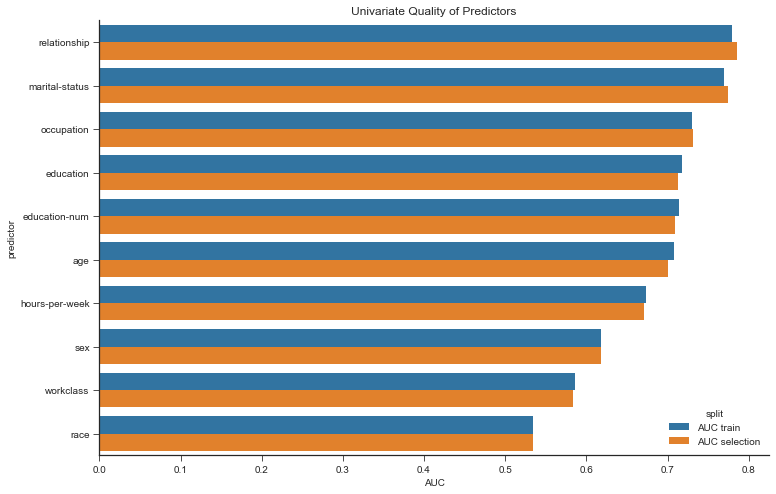

In [7]:
# univariate feature importance
plot_univariate_predictor_quality(df_auc)

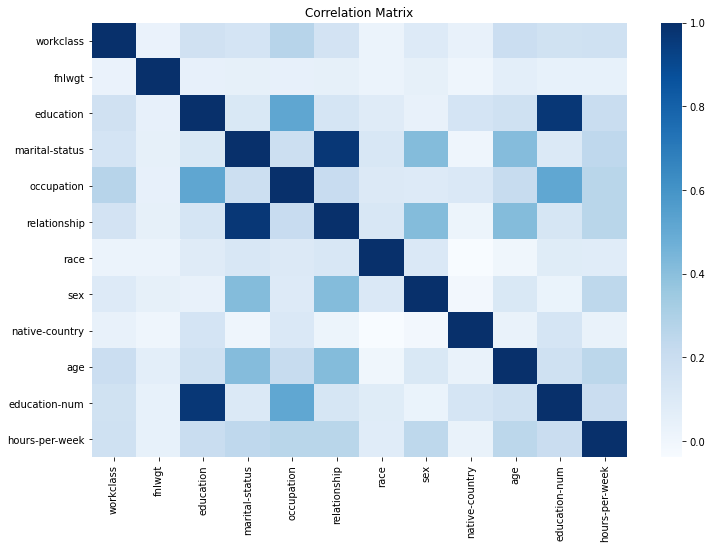

In [8]:
# compute correlations between preprocessed predictors
df_corr = (univariate_selection
           .compute_correlations(basetable[basetable["split"] == "train"],
                                 preprocessed_predictors))

plot_correlation_matrix(df_corr)

## Modelling
After having preselected the features, we can start modelling using forward feature selection.

Since we use target encoding on all our predictors, we will only consider models with positive coefficients (no sign flip should occur) as this makes the model more interpretable.


In [9]:
forward_selection = ForwardFeatureSelection(max_predictors=30,
                                            pos_only=True)

forward_selection.fit(basetable[basetable["split"] == "train"],
                      target_column_name,
                      preselected_predictors)

performances = (forward_selection
                .compute_model_performances(basetable, target_column_name))

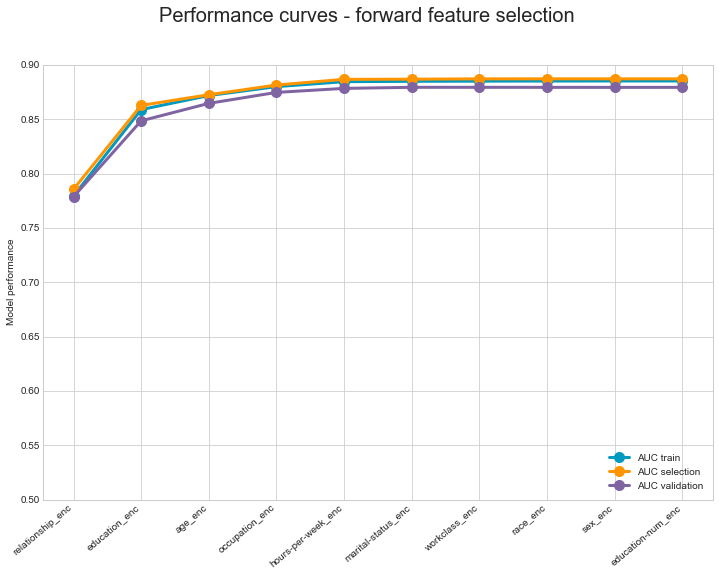

In [10]:
# plot performance curves
plot_performance_curves(performances)

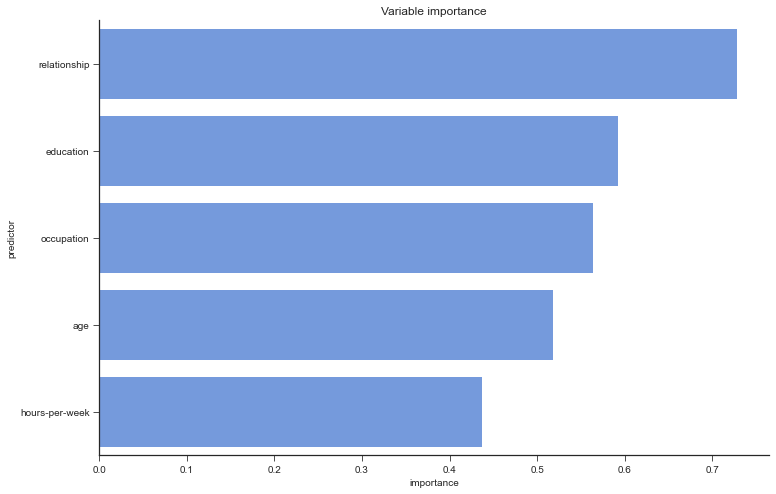

In [11]:
# after plotting the performances and selecting the model,
model = forward_selection.get_model_from_step(4)

# we have chosen model with 5 variables, which we extract as follows
final_predictors = model.predictors

# we can also compute and plot the importance of each predictor in the model:
variable_importance = model.compute_variable_importance(
    basetable[basetable["split"] == "selection"])

# this is correlation of the model score and predictor    
plot_variable_importance(variable_importance)

## Evaluation

Next step after modelling is to evaluate how well is our model performing

In [12]:
# get numpy array of True target labels and predicted scores
y_true = basetable[basetable["split"] == "selection"][target_column_name].values
y_pred = model.score_model(basetable[basetable["split"] == "selection"])

evaluator = Evaluator()

# automatically finds the best cut-off probability
evaluator.fit(y_true, y_pred)

In [13]:
# get various scalar metrics such as accuracy, AUC, precision, recall, ...
evaluator.scalar_metrics

accuracy             0.801597
AUC                  0.886623
precision            0.559809
recall               0.800684
F1                   0.658923
matthews_corrcoef    0.541860
lift at  0.05        3.560000
dtype: float64

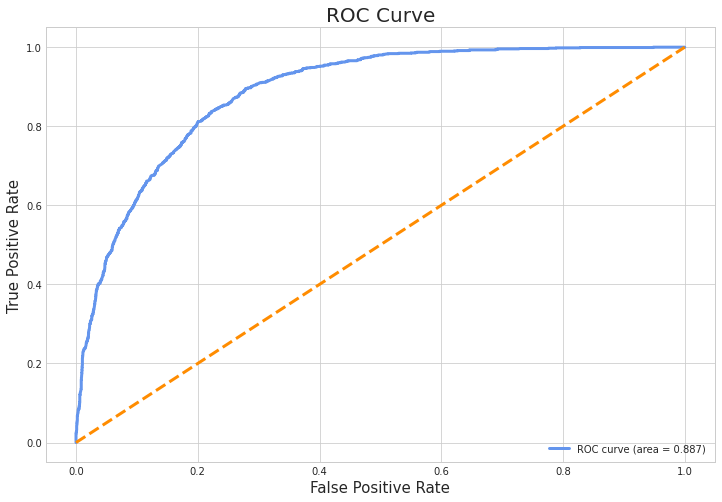

In [14]:
evaluator.plot_roc_curve()

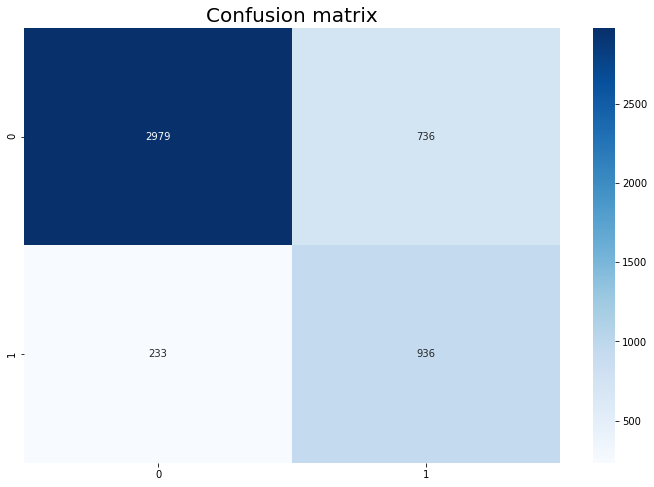

In [15]:
evaluator.plot_confusion_matrix()

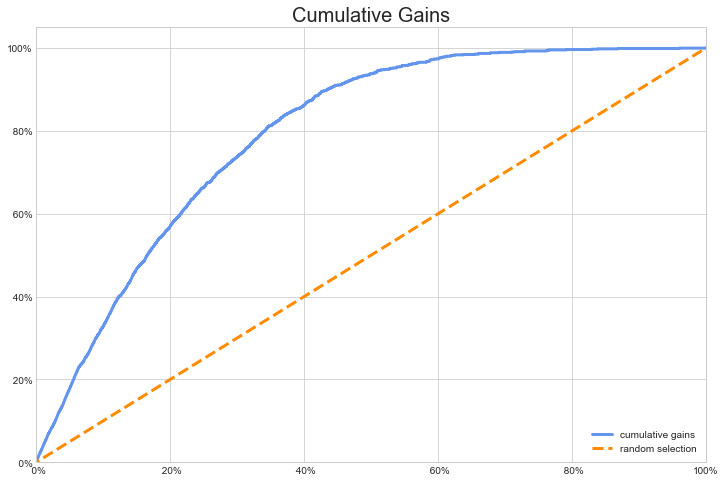

In [16]:
evaluator.plot_cumulative_gains()

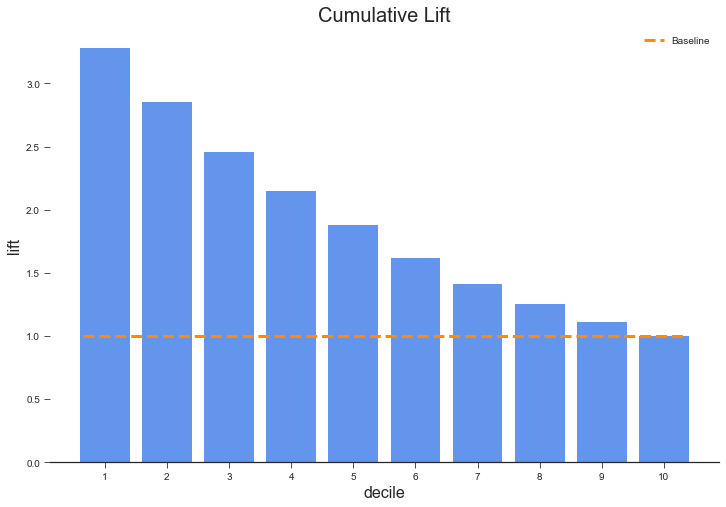

In [17]:
evaluator.plot_lift_curve()

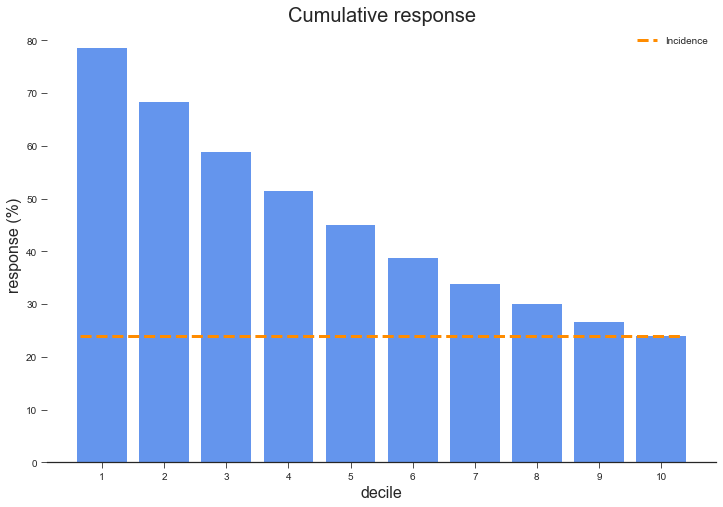

In [18]:
evaluator.plot_cumulative_response_curve()

## PIG tables
Predictor Incidence Graphs, or PIGs, are plots which help us understand how each variable behaves in the model.

In [19]:
predictor_list = [col for col in basetable.columns
                  if col.endswith("_bin") or col.endswith("_processed")]

pig_tables = generate_pig_tables(
    basetable[basetable["split"] == "selection"],
    id_column_name='ID',
    target_column_name=target_column_name,
    preprocessed_predictors=predictor_list)

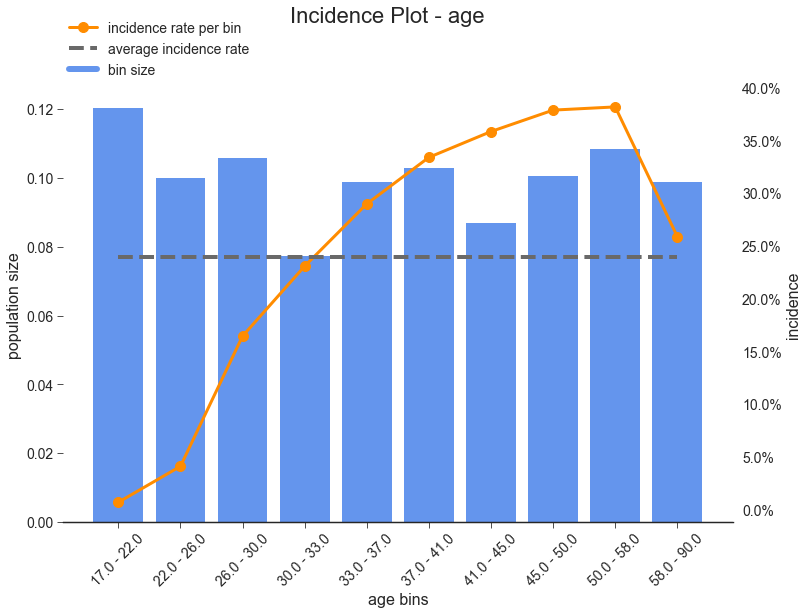

In [20]:
column_age_order = ['17.0 - 22.0', '22.0 - 26.0', '26.0 - 30.0', '30.0 - 33.0',
                    '33.0 - 37.0', '37.0 - 41.0', '41.0 - 45.0', '45.0 - 50.0',
                    '50.0 - 58.0', '58.0 - 90.0']              

plot_incidence(pig_tables, 'age', column_age_order)

In [21]:
pig_tables.head(n=10)

,variable,label,pop_size,avg_incidence,incidence
0,age,17.0 - 22.0,0.120393,0.239353,0.006803
1,age,22.0 - 26.0,0.100123,0.239353,0.040900
2,age,26.0 - 30.0,0.105856,0.239353,0.164410
3,age,30.0 - 33.0,0.077191,0.239353,0.230769
4,age,33.0 - 37.0,0.098894,0.239353,0.289855
5,age,37.0 - 41.0,0.102989,0.239353,0.333996
6,age,41.0 - 45.0,0.086814,0.239353,0.358491
7,age,45.0 - 50.0,0.100532,0.239353,0.378819
8,age,50.0 - 58.0,0.108313,0.239353,0.381853
9,age,58.0 - 90.0,0.098894,0.239353,0.258799


## Industrialization

Once we are happy with out model, we can industrialize it. All the preprocessing is in the output pipeline in a JSON format. The model comes from sklearn, which can be easily serialized and exported.

In [22]:
with open(ROOT/'pipeline.json', "r") as read_file:
    pipeline = json.load(read_file)

print(pipeline.keys())


dict_keys(['metadata', 'categorical_data_processor', 'discretizer', 'target_encoder', '_is_fitted'])


In [23]:
pipeline['target_encoder']['_mapping']['age_bin']

{'17.0 - 22.0': 0.004045996592844974,
 '22.0 - 26.0': 0.04875545291249679,
 '26.0 - 30.0': 0.1473605203902927,
 '30.0 - 33.0': 0.21855146124523506,
 '33.0 - 37.0': 0.2868525896414343,
 '37.0 - 41.0': 0.3374841168996188,
 '41.0 - 45.0': 0.3715661285754744,
 '45.0 - 50.0': 0.40084277060837503,
 '50.0 - 58.0': 0.37187878787878786,
 '58.0 - 90.0': 0.25625}